# Experiments and Documentation (1st)

#### Load required packages and dependencies

In [1]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from spglm.iwls import _compute_betas_gwr, iwls  
from spglm.family import Gaussian
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from statsmodels.api import OLS

In [2]:
import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=3, suppress=True)

### Data Generating Process

##### 1. Simulate different spatial supports

In [3]:
def simulate_S1_S2(num_points1, num_points2):
    """
    Function to simulate two different spatial supports. S1 and S2. It also returns their locations. 
    """
    np.random.seed(26)
    locations1 = np.random.rand(num_points1, 2) * 100
    centers = [(30, 30), (70, 70), (30, 70), (70, 30)]
    locations2, _ = make_blobs(n_samples=num_points2, centers=centers, cluster_std=10.0, random_state=26)
    locations2 = np.clip(locations2, 0, 100)
    s1 = np.random.normal(50, 20, num_points1)
    s2 = np.random.normal(100, 50, num_points2)
    return s1, locations1, s2, locations2
    

S1, loc1, S2, loc2 = simulate_S1_S2(200, 350) # function call to create the spatial supports

##### 2. Function to create Beta surfaces with varying levels of spatial heterogeneity

In [4]:
def create_beta_surface(locations, heterogeneity='low'):
    """
    Create beta surface with low or high spatial heterogeneity. defaults to low if none is specified.  
    """
    x, y = locations[:, 0], locations[:, 1]
    if heterogeneity == 'low':
        B = x / 10 + y / 10
    elif heterogeneity == 'high':
        B = np.sin(x/10) * np.cos(y/10) + (x-50)**2/100 + (y-50)**2/100
    return B
    surface = 1 + 1/324 * (36*(6*x_locations_norm-2)**2) * (36*(6*y_locations_norm-2)**2)
    
    return surface

def uniform(locations):
    """
    Create constant surface with uniform/constant heterogeneity. 
    """
    surface = np.full(len(locations), 5)
    
    return surface


# Initialize beta

Beta_H = create_beta_surface(loc1, heterogeneity='high')
Beta_L = create_beta_surface(loc1, heterogeneity='low')
Beta_U = uniform(loc1)

3. ##### Visualize the beta surfaces. 

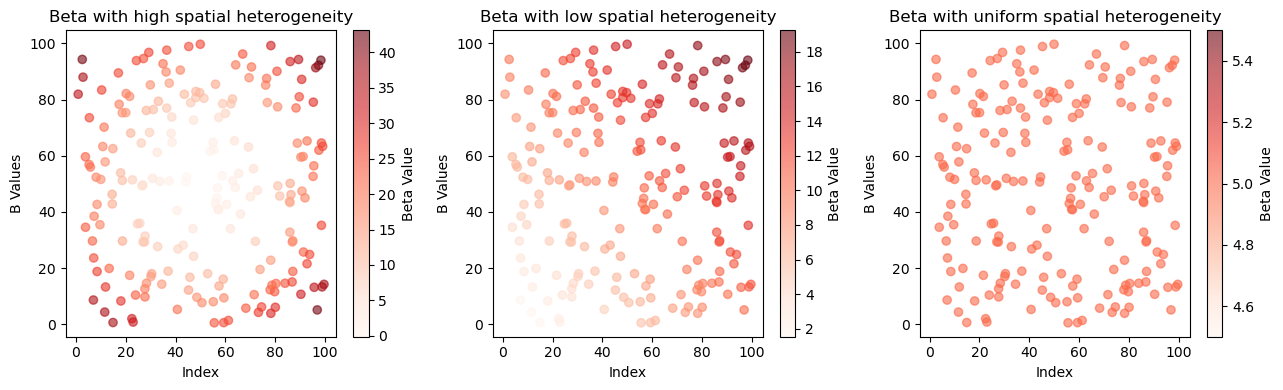

In [5]:
plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.scatter(loc1[:,0], loc1[:, 1], c=Beta_H, cmap='Reds', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with high spatial heterogeneity')

plt.subplot(1, 3, 2)
plt.scatter(loc1[:,0], loc1[:, 1], c=Beta_L, cmap='Reds', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with low spatial heterogeneity')

plt.subplot(1, 3, 3)
plt.scatter(loc1[:,0], loc1[:, 1], c=Beta_U, cmap='Reds', alpha=0.6)
plt.xlabel('Index')
plt.ylabel('B Values')
plt.colorbar(label='Beta Value')
plt.title('Beta with uniform spatial heterogeneity')


plt.tight_layout()
plt.show()


##### 4. Generate y as a function of B*X

In [6]:
# Generate y values
nbrs_S2 = NearestNeighbors(n_neighbors=35).fit(loc2)
smoothed_S2_to_S1 = np.zeros(len(S1))
for i in range(len(S1)):
    distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
    smoothed_S2_to_S1[i] = np.mean(S2[indices_S1_to_S2[0]])
    

y_H = Beta_H * smoothed_S2_to_S1
y_L = Beta_L * smoothed_S2_to_S1
y_U = Beta_U * smoothed_S2_to_S1

In [7]:
# Gaussian family initialization
family = Gaussian()

### Utility functions to compute AICc, Loglikelihood, and visualization

In [8]:
def calculate_aicc_rss(n, RSS, tr_S):
    """GWR-style AICc calculation using RSS and trace of the hat matrix (tr_S)."""
    # aicc = (n * np.log((RSS)/(n-tr_S))) + (n * np.log(2*np.pi)) + (n*((n+tr_S)/(n-2-tr_S)))
    term1 = 2 * n * np.log(RSS / n)
    term2 = n * np.log(2 * np.pi)
    term3 = n * ((n + tr_S) / (n - 2 - tr_S))
    
    aicc = term1 + term2 + term3
    return aicc
    
def calculate_aicc(n, log_likelihood, tr_S):
    """GWR-style AICc calculation using log-likelihood and trace of the hat matrix (tr_S)."""
    aic = -2 * log_likelihood + 2 * (tr_S + 1)
    aicc = aic + (2 * tr_S * (tr_S + 1)) / (n - tr_S - 1)
    return aicc

def log_likelihood_gaussian(residuals, n):
    """Calculate log-likelihood for Gaussian model."""
    sigma2 = np.sum(residuals**2) / n
    log_likelihood = -0.5 * n * (np.log(2 * np.pi * sigma2) + 1)
    return log_likelihood
    
def plot_true_and_recovered(true, recovered, coord):
    """
    Utility function to generate visualize of true beta surfaces and recovered betas surface by the local model
    """
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(coord[:,0], coord[:, 1], c=true, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('True B Values')
    plt.colorbar(label='Beta Value')
    plt.title('True B Values')
    
    plt.subplot(1, 2, 2)
    plt.scatter(coord[:,0], coord[:, 1], c=recovered, cmap='Reds', alpha=0.6)
    plt.xlabel('Index')
    plt.ylabel('recovered B Values')
    plt.colorbar(label='Beta Value')
    plt.title('recovered B Values')
    
    plt.tight_layout()
    plt.show()
    

### Change of Support GWR

In [9]:
def perform_local_regression(n_neighbor_est, loc1, loc2, S2, y):
    """
    Function that implements change of support into a GWR-like local model
    """
    recovered_betas = np.zeros(len(S1))
    residuals = np.zeros(len(S1))
    N = len(S1)
    
    resid_SS = []
    R = np.zeros((N, N))
    S = np.zeros((N, N))

    for i in range(len(S1)):
        # Find neighbors in S2 for current S1_i for smoothing
        nbrs_S2 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc2)
        distances_S1_to_S2, indices_S1_to_S2 = nbrs_S2.kneighbors([loc1[i]])
        
        local_X = []
        weights_X = []
        
        # Smooth S2 onto S1 within the local regression function
        for j, neighbor_index_S2 in enumerate(indices_S1_to_S2[0]):
            dist_j_to_i = distances_S1_to_S2[0][j]
            weight = np.exp(-0.5 * (dist_j_to_i / 10)**2)
            local_X.append(S2[neighbor_index_S2])
            weights_X.append(weight)

        local_X = np.array(local_X)
        weights_X = np.array(weights_X)
        weighted_X_i = np.sum(local_X * weights_X) / np.sum(weights_X)

        # Local regression using weighted S2 data at S1_i
        nbrs_S1 = NearestNeighbors(n_neighbors=n_neighbor_est).fit(loc1)
        distances, indices = nbrs_S1.kneighbors([loc1[i]])

        y_neighbors = y[indices[0]].reshape(-1, 1)
        X_neighbors = weighted_X_i * np.ones(len(indices[0])).reshape(-1, 1)

        weights_y = np.exp(-0.5 * (distances[0] / 10)**2).reshape(-1, 1)

        rslt = iwls(y_neighbors, X_neighbors, family, None, None, None, 1.0e-5, 20, wi=weights_y)

        recovered_betas[i] = rslt[0]
    
        ri = np.dot(X_neighbors, rslt[5])

    R[i, indices[0]] = ri[0]
    S[i, indices[0]] = ri[0] * rslt[4].flatten()
        
    y_pred_i = np.dot(X_neighbors[0], rslt[0])
    
    residuals[i] = y[i] - y_pred_i
    
    RSS = np.sum(residuals**2)
    resid_SS.append(RSS)
    
    # Calculate trace of S
    tr_S = np.trace(S)
    

    log_likelihood = log_likelihood_gaussian(residuals, len(S1)) # not used
    aicc_ll = calculate_aicc(len(S1), log_likelihood, tr_S) # not used
    
    aicc = calculate_aicc_rss(len(S1), RSS, tr_S) # both RSS & LL gives the same/near similar result
                                                  # But I prefer to use the RSS calculation because its more GWR-centric

    return recovered_betas, aicc, tr_S

### Get Diagnostics

### True beta and bandwidth recovery with HIGH spatial heterogeneity

<strong> Expected behavior: </strong>
<br /> 
<br />
1. If the method works well, it should be able to recover the beta parameters. <br /> <br />
2. It should also be able to recover the scale of the beta surface. In this experiement, we use a beta surface with high spatial variability, so we expect the method to select a small bandwidth.

In [10]:
# Define range for number of neighbors
neighbors_values = list(range(11, 150, 2))
best_aicc = float('inf')
best_neighbors = None
recovered_betas_best = None

aicc_values = []
enp_values = []

# Iterate over neighbor values
for n_neighbors in neighbors_values:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_H)
    aicc_values.append(aicc)
    enp_values.append(enp)
    if aicc < best_aicc:
        best_aicc = aicc
        best_neighbors = n_neighbors
        recovered_betas_best = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors}")
print(f"Best AICc: {best_aicc:.2f}")

Optimal number of neighbors: 23
Best AICc: 1978.19


In [11]:
dict_aicc = dict(zip(neighbors_values, aicc_values))
min(dict_aicc, key=dict_aicc.get)

23

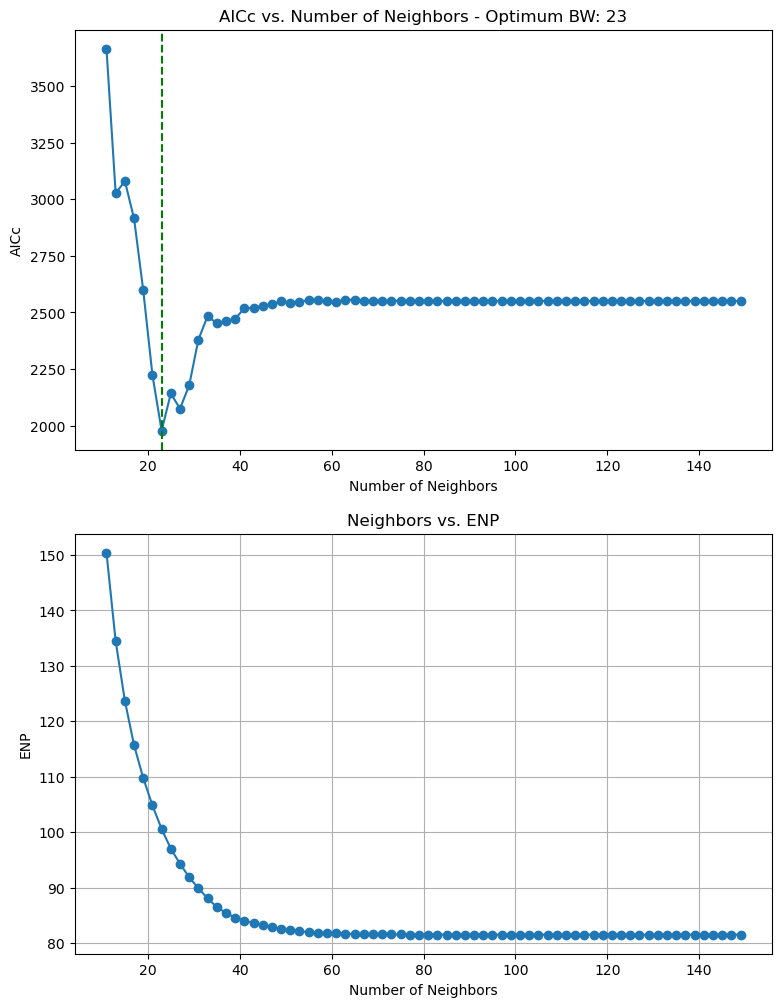

In [12]:
plt.figure(figsize=(9, 12))

plt.subplot(2, 1, 1)
plt.plot(neighbors_values, aicc_values, marker='o')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title(f'AICc vs. Number of Neighbors - Optimum BW: {min(dict_aicc, key=dict_aicc.get)}')
# plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(neighbors_values, enp_values, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('ENP')
plt.title('Neighbors vs. ENP')
plt.grid(True)

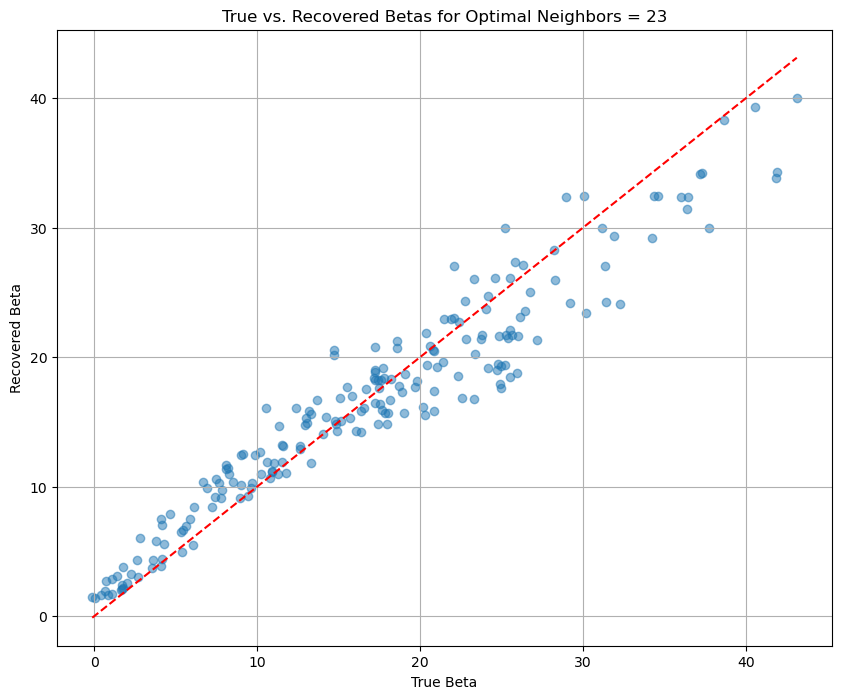

In [13]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(Beta_H, recovered_betas_best, alpha=0.5)
plt.plot([Beta_H.min(), Beta_H.max()], [Beta_H.min(), Beta_H.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors}')
plt.grid(True)
plt.show()

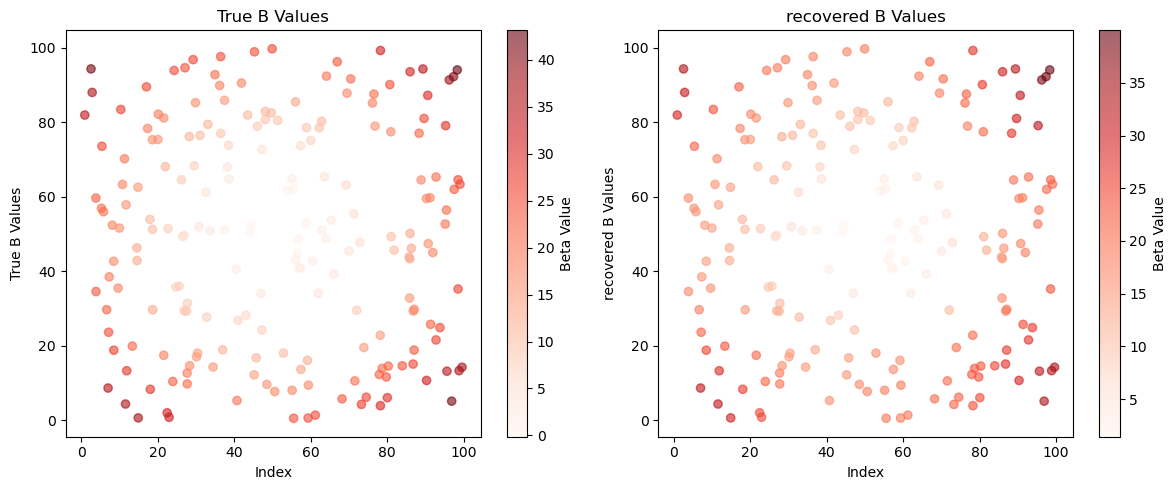

In [14]:
plot_true_and_recovered(Beta_H, recovered_betas_best, loc1)

#### Compare against GWR

Using the Smoothed S2 to S1 as the design matrix for GWR

In [15]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc

In [16]:
gwr_X = smoothed_S2_to_S1.reshape(-1, 1)
gwr_y = y_H.reshape(-1, 1)
coords = loc1

In [17]:
coords.shape, gwr_y.shape, gwr_X.shape

((200, 2), (200, 1), (200, 1))

In [18]:
aicc_gwr = []
params = []
ENP = []
bwvalue = list(range(3, 150, 2))
for i in bwvalue:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params.append(model.params)
    aicc_gwr.append(model.aicc)
    ENP.append(model.ENP)

In [19]:
dict_aicc = dict(zip(bwvalue, aicc_gwr))

In [20]:
min(dict_aicc, key=dict_aicc.get)

9

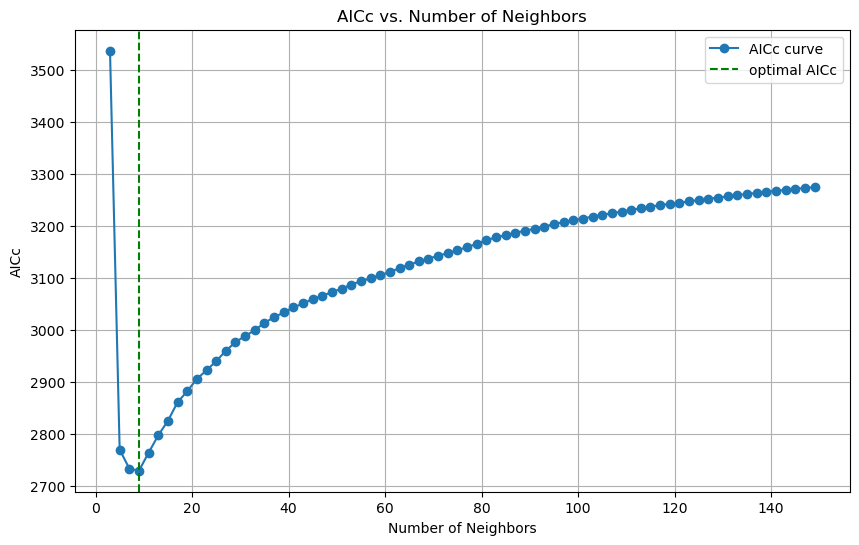

In [21]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue, aicc_gwr, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc, key=dict_aicc.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

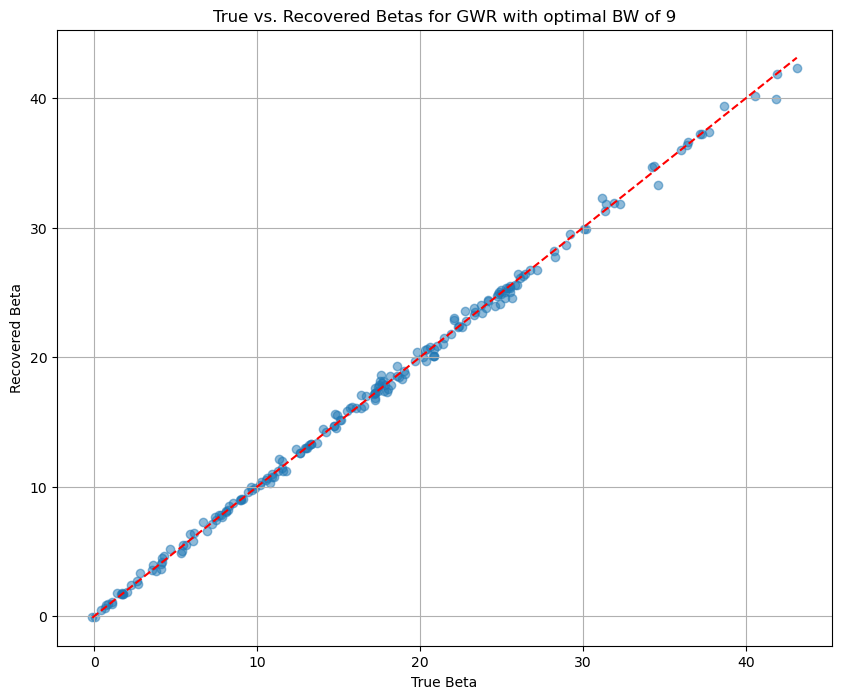

In [22]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(Beta_H, params[0],
            alpha=0.5)
plt.plot([Beta_H.min(), Beta_H.max()], [Beta_H.min(), Beta_H.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc, key=dict_aicc.get)}")
plt.grid(True)
plt.show()

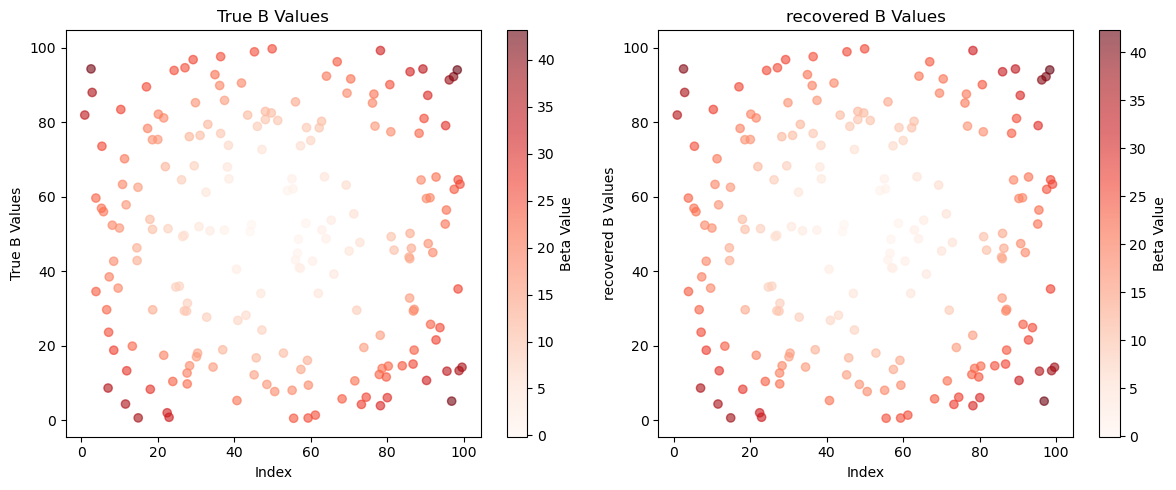

In [23]:
plot_true_and_recovered(Beta_H, params[0], loc1)

<strong> In conclusion: </strong>
<br /> 
<br />
The proposed method selected a low bandwidth of 23 nearest neighbors. When compared to GWR, an even smaller bandwidth of 9 was observed, along with a tighter recovery of the true beta values. It is important to note that GWR is currently prone to the double smoothing issue because the smoothed S2 to S1 was used in both the DGP and in the modelling. This might explain the tight recovery of the true beta values. 

### True beta & bandwidth recovery with LOW spatial heterogeneity

<strong> Expected behavior: </strong>
<br /> 
<br />
1. This time, a beta surface with low spatial variability was used <br /> <br />
2. The method is expected to recover the true betas, as well as select a bandwidth that reflects the low spatial variability in the process. 


In [24]:
# Define range for number of neighbors
neighbors_values_LOW = list(range(11, 150, 2))
best_aicc_LOW = float('inf')
best_neighbors_LOW = None
recovered_betas_best_LOW = None

aicc_values_LOW = []
enp_values_LOW = []

# Iterate over neighbor values
for n_neighbors in neighbors_values_LOW:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_L)
    aicc_values_LOW.append(aicc)
    enp_values_LOW.append(enp)
    if aicc < best_aicc_LOW:
        best_aicc_LOW = aicc
        best_neighbors_LOW = n_neighbors
        recovered_betas_best_LOW = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors_LOW}")
print(f"Best AICc: {best_aicc_LOW:.2f}")

Optimal number of neighbors: 97
Best AICc: 628.28


In [25]:
dict_aicc_LOW = dict(zip(neighbors_values_LOW, aicc_values_LOW))
min(dict_aicc_LOW, key=dict_aicc_LOW.get)

97

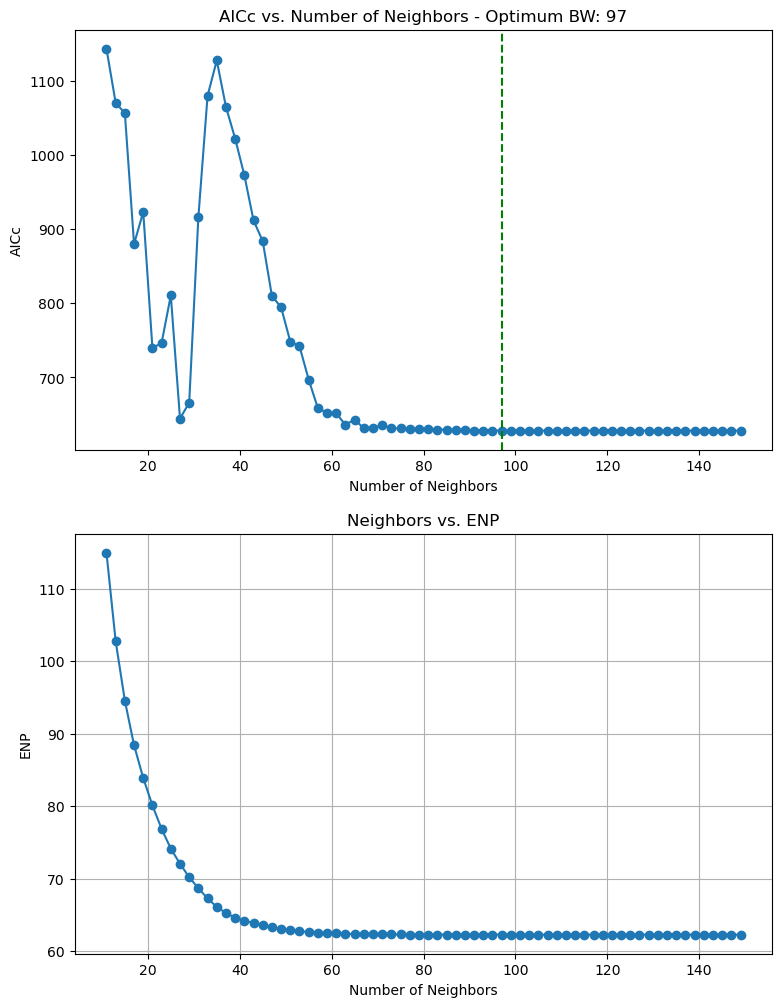

In [26]:
plt.figure(figsize=(9, 12))

plt.subplot(2, 1, 1)
plt.plot(neighbors_values_LOW, aicc_values_LOW, marker='o')
plt.axvline(min(dict_aicc_LOW, key=dict_aicc_LOW.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title(f'AICc vs. Number of Neighbors - Optimum BW: {min(dict_aicc_LOW, key=dict_aicc_LOW.get)}')
# plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(neighbors_values_LOW, enp_values_LOW, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('ENP')
plt.title('Neighbors vs. ENP')
plt.grid(True)

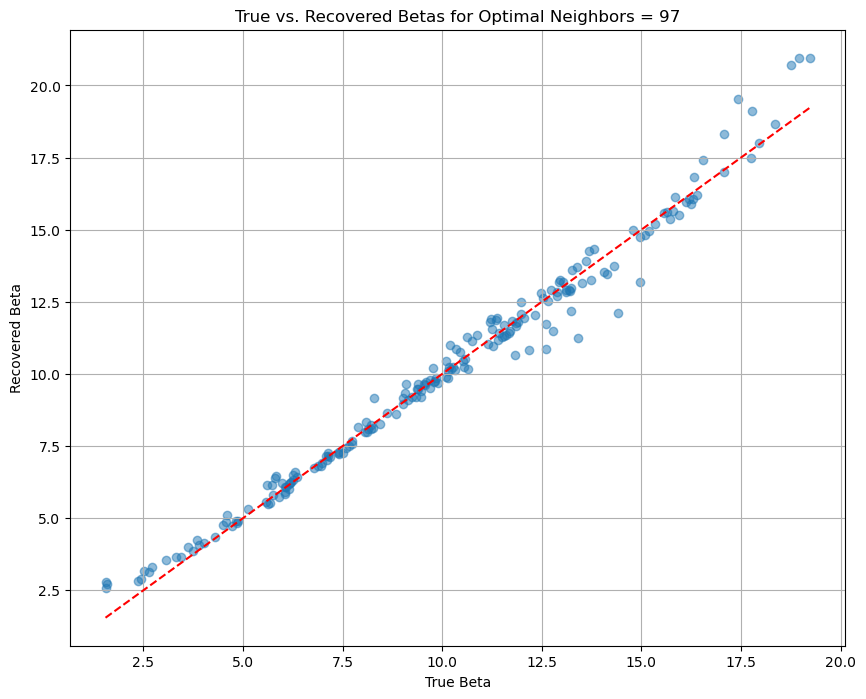

In [27]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(Beta_L, recovered_betas_best_LOW, alpha=0.5)
plt.plot([Beta_L.min(), Beta_L.max()], [Beta_L.min(), Beta_L.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors_LOW}')
plt.grid(True)
plt.show()

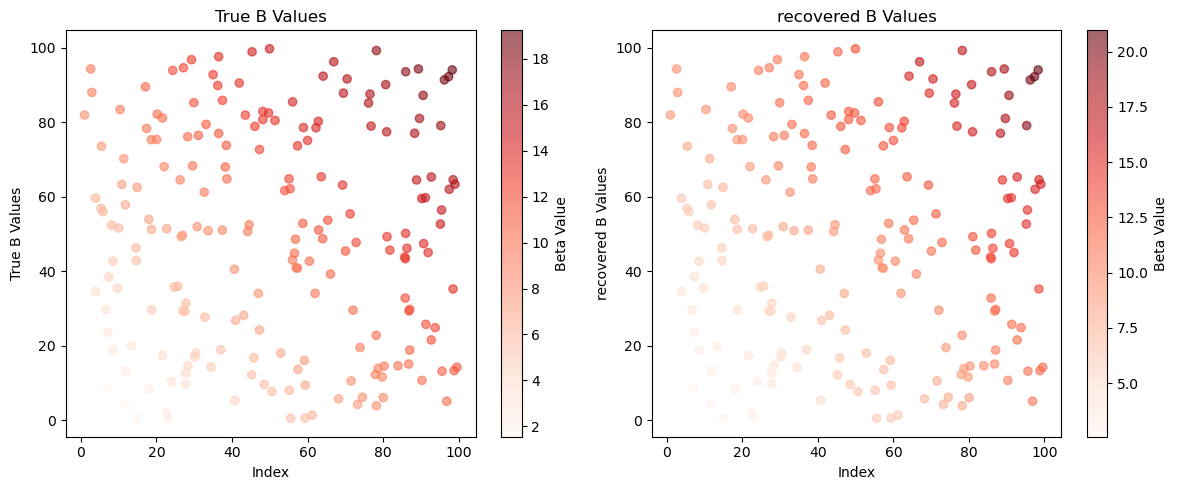

In [28]:
plot_true_and_recovered(Beta_L, recovered_betas_best_LOW, loc1)

#### Compare against GWR

In [29]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc

Using the Smoothed S2 to S1 as the design matrix for GWR

In [30]:
gwr_X = smoothed_S2_to_S1.reshape(-1, 1)
gwr_y = y_L.reshape(-1, 1)
coords = loc1

In [31]:
coords.shape, gwr_y.shape, gwr_X.shape

((200, 2), (200, 1), (200, 1))

In [32]:
aicc_gwr_LOW = []
params_LOW = []
ENP_LOW = []
bwvalue_LOW = list(range(3, 150, 2))
for i in bwvalue_LOW:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params_LOW.append(model.params)
    aicc_gwr_LOW.append(model.aicc)
    ENP_LOW.append(model.ENP)

In [33]:
dict_aicc_LOW = dict(zip(bwvalue_LOW, aicc_gwr_LOW))

In [34]:
min(dict_aicc_LOW, key=dict_aicc_LOW.get)

9

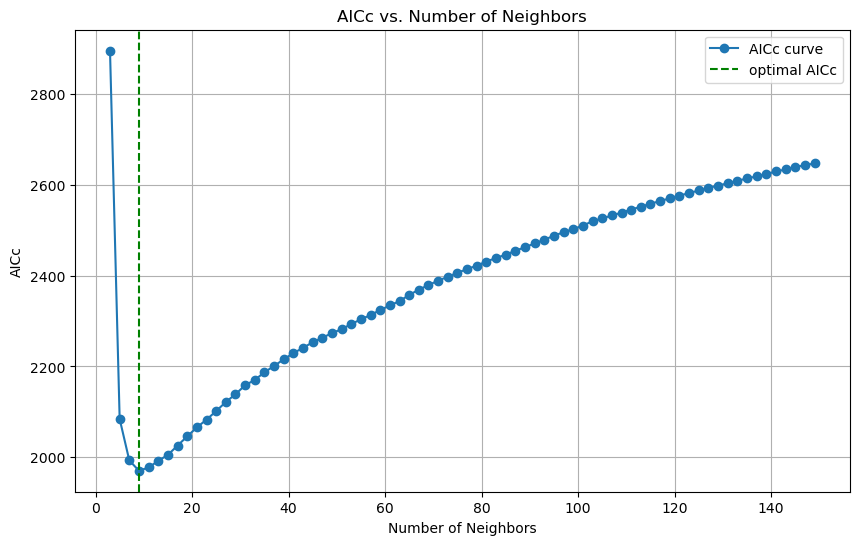

In [35]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue_LOW, aicc_gwr_LOW, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc_LOW, key=dict_aicc_LOW.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

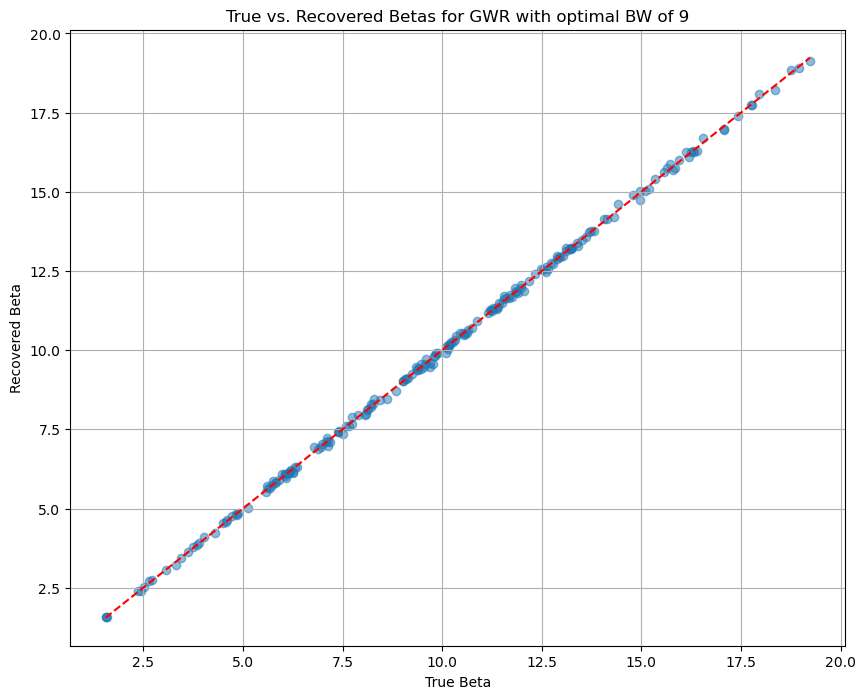

In [36]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(Beta_L, params_LOW[0],
            alpha=0.5)
plt.plot([Beta_L.min(), Beta_L.max()], [Beta_L.min(), Beta_L.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc_LOW, key=dict_aicc_LOW.get)}")
plt.grid(True)
plt.show()

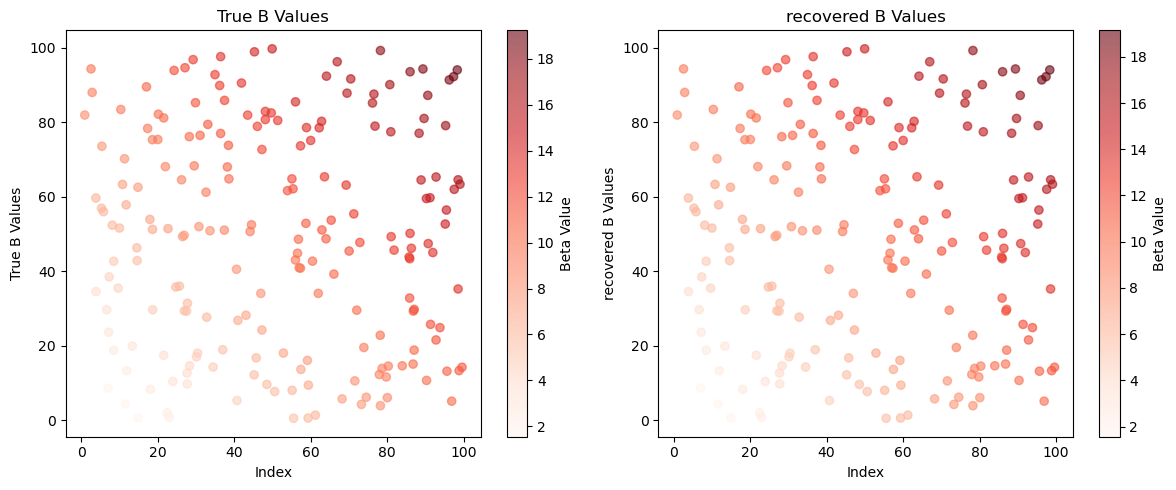

In [37]:
plot_true_and_recovered(Beta_L, params_LOW[0], loc1)

<strong> Conclusion </strong>
<br /> 
<br />
The proposed method was able to recover the true betas and selected 97 as the optimal bandwidth, which seems appropriate given the nature of the beta surface. GWR, on the other hand, selected 9 as the optimal bandwith, which seems a bit off. However, it recovered the true betas with a much tighter fit than the proposed method. 


### True beta & bandwidth recovery with UNI spatial heterogeneity

<strong> Expected behavior: </strong>
<br /> 
<br />
1. This experiment specifically tests whether the method can recover the true betas and select a bandwidth that reflects global process in the constant surface <br /> <br />
2. The method is expected to recover the true betas and select a large bandwidth that reflects the global/uniform process in the beta surface. 


In [38]:
# Define range for number of neighbors
neighbors_values_UNI = list(range(11, 200, 2))
best_aicc_UNI = float('inf')
best_neighbors_UNI = None
recovered_betas_best_UNI = None

aicc_values_UNI = []
enp_values_UNI = []

# Iterate over neighbor values
for n_neighbors in neighbors_values_UNI:
    recovered_betas, aicc, enp = perform_local_regression(n_neighbors, loc1, loc2, S2, y_U)
    aicc_values_UNI.append(aicc)
    enp_values_UNI.append(enp)
    if aicc < best_aicc_UNI:
        best_aicc_UNI = aicc
        best_neighbors_UNI = n_neighbors
        recovered_betas_best_UNI = recovered_betas

print(f"Optimal number of neighbors: {best_neighbors_UNI}")
print(f"Best AICc: {best_aicc_UNI:.2f}")

Optimal number of neighbors: 197
Best AICc: 248.92


In [39]:
dict_aicc_UNI = dict(zip(neighbors_values_UNI, aicc_values_UNI))
min(dict_aicc_UNI, key=dict_aicc_UNI.get)

197

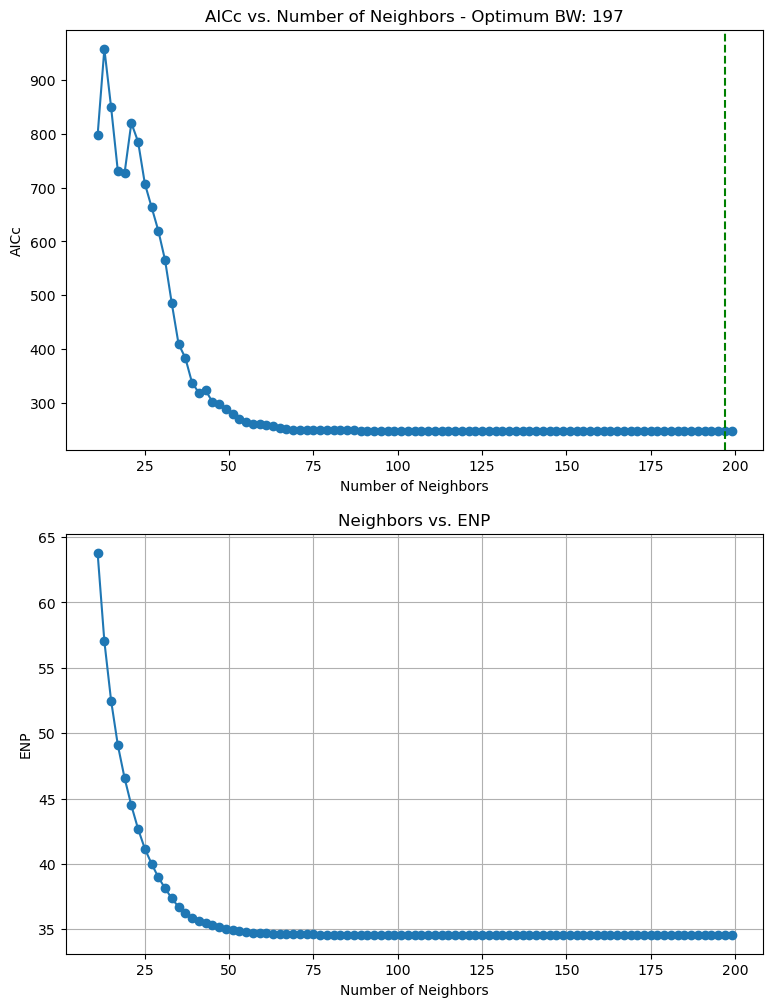

In [40]:
plt.figure(figsize=(9, 12))

plt.subplot(2, 1, 1)
plt.plot(neighbors_values_UNI, aicc_values_UNI, marker='o')
plt.axvline(min(dict_aicc_UNI, key=dict_aicc_UNI.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.title(f'AICc vs. Number of Neighbors - Optimum BW: {min(dict_aicc_UNI, key=dict_aicc_UNI.get)}')
# plt.grid(True)


plt.subplot(2, 1, 2)
plt.plot(neighbors_values_UNI, enp_values_UNI, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('ENP')
plt.title('Neighbors vs. ENP')
plt.grid(True)

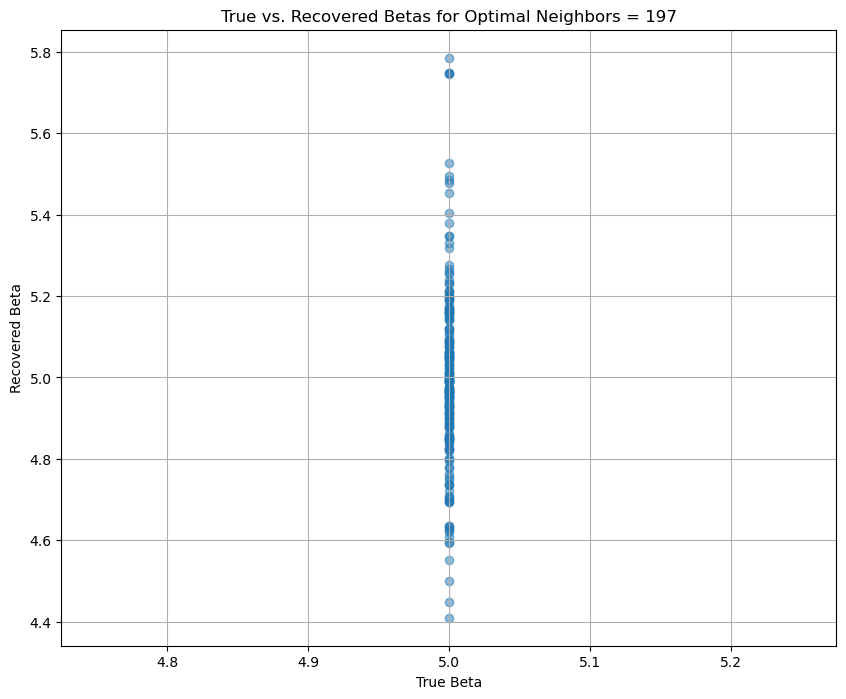

In [41]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors

plt.figure(figsize=(10, 8))
plt.scatter(Beta_U, recovered_betas_best_UNI, alpha=0.5)
plt.plot([Beta_U.min(), Beta_U.max()], [Beta_U.min(), Beta_U.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f'True vs. Recovered Betas for Optimal Neighbors = {best_neighbors_UNI}')
plt.grid(True)
plt.show()

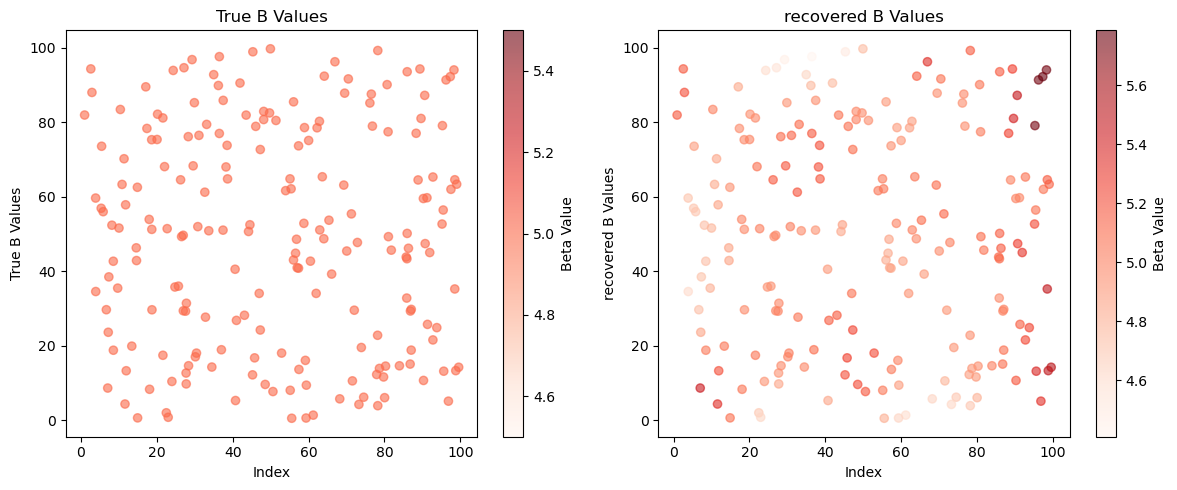

In [42]:
plot_true_and_recovered(Beta_U, recovered_betas_best_UNI, loc1)

#### Compare against GWR

In [43]:
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.diagnostics import get_AICc

Using the Smoothed S2 to S1 as the design matrix for GWR

In [44]:
gwr_X = smoothed_S2_to_S1.reshape(-1, 1)
gwr_y = y_U.reshape(-1, 1)
coords = loc1

In [45]:
coords.shape, gwr_y.shape, gwr_X.shape

((200, 2), (200, 1), (200, 1))

In [46]:
aicc_gwr_UNI = []
params_UNI = []
ENP_UNI = []
bwvalue_UNI = list(range(3, 150, 2))
for i in bwvalue_UNI:
    model = GWR(coords, gwr_y, gwr_X, i, constant=False).fit()
    params_UNI.append(model.params)
    aicc_gwr_UNI.append(model.aicc)
    ENP_UNI.append(model.ENP)

In [47]:
dict_aicc_UNI = dict(zip(bwvalue_UNI, aicc_gwr_UNI))

In [48]:
min(dict_aicc_UNI, key=dict_aicc_UNI.get)

27

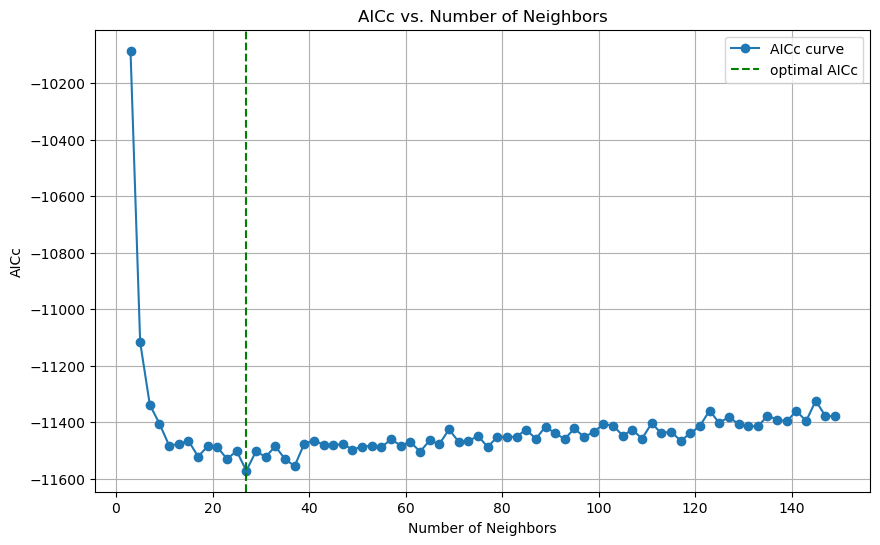

In [49]:
# Plotting AICc vs. number of neighbors
plt.figure(figsize=(10, 6))
plt.plot(bwvalue_UNI, aicc_gwr_UNI, marker='o', label='AICc curve')
plt.axvline(min(dict_aicc_UNI, key=dict_aicc_UNI.get), linestyle='--', color='green', label='optimal AICc')
plt.xlabel('Number of Neighbors')
plt.ylabel('AICc')
plt.legend()
plt.title('AICc vs. Number of Neighbors')
plt.grid(True)
plt.show()

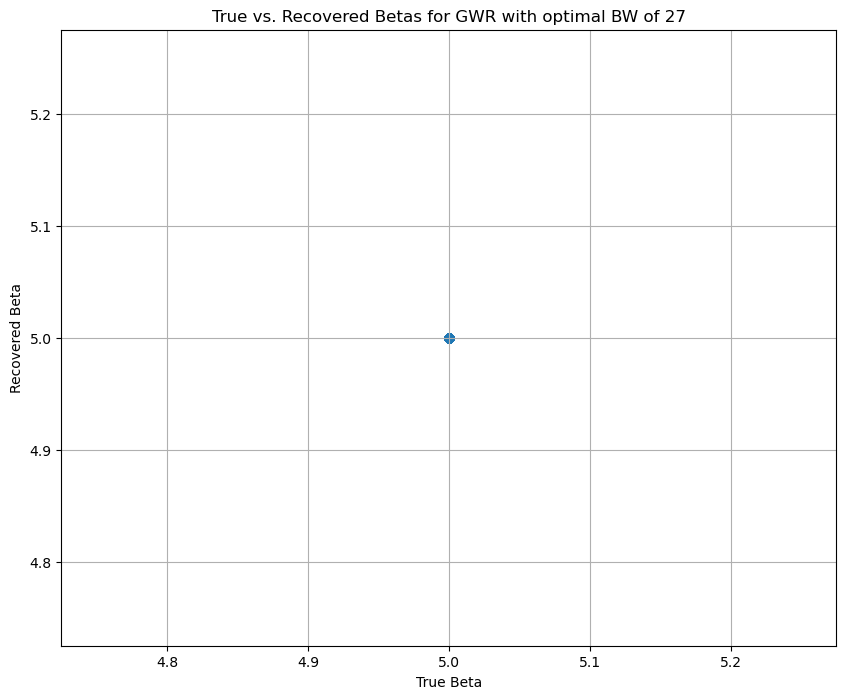

In [50]:
# Plot True Beta vs Recovered Beta for the optimal number of neighbors
plt.figure(figsize=(10, 8))
plt.scatter(Beta_U, params_UNI[0].flatten(),
            alpha=0.5)
plt.plot([Beta_U.min(), Beta_U.max()], [Beta_U.min(), Beta_U.max()], 'r--')  # Line of equality
plt.xlabel('True Beta')
plt.ylabel('Recovered Beta')
plt.title(f"True vs. Recovered Betas for GWR with optimal BW of {min(dict_aicc_UNI, key=dict_aicc_UNI.get)}")
plt.grid(True)
plt.show()

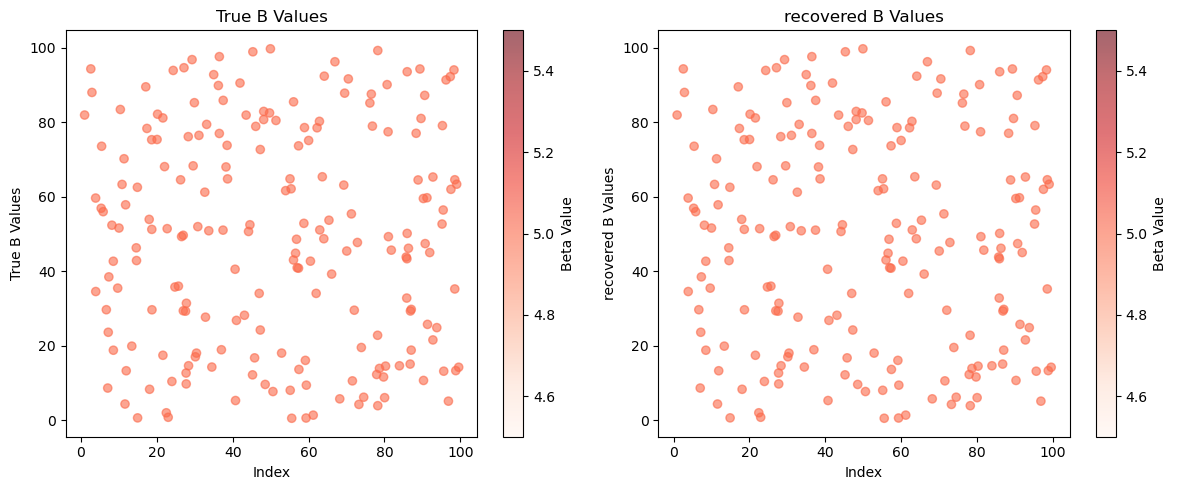

In [51]:
plot_true_and_recovered(Beta_U, params_UNI[0], loc1)

<strong> Conclusion </strong>
<br /> 
<br />

The proposed method recovered the true beta parameters and selected 197 as the optimal bandwidth, whereas GWR selected 27 as the optimal bandwidth. A bandwidth of 197 seems appropriate given the constant beta surface. Therefore, the expectation that the method should recover the true beta values and select a very high bandwidth, equivalent to a global model, was met. 

|


<strong> 
In all 3 experiments, the proposed method appears to recover the true betas as well as the scale of the beta surfaces. When compared to the traditional GWR, it is observed that GWR struggles with recovering the true scale of the beta surfaces. Although GWR shows better prospects at recovering the true betas than the proposed method, it is not theoretically the best approach, considering the fact that the same design matrix is used in both the DGP and the modeling. Additionally, GWR is built on the assumption that all data must be on the same spatial support. 

<strong />